In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from collections import Counter

In [2]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

In [3]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):
    
    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [4]:
def get_cluster_dfs(df, cluster):
    return[df[cluster == i] for i in np.unique(cluster)]

In [5]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [164]:
aggr = aggregate_by_label(df, 'Language', 1)

In [165]:
tfidf = TfidfVectorizer(
    stop_words=get_stop_words('de'),
    max_features=250,
    ngram_range=(1,3))

X = tfidf.fit_transform(aggr.text)
X = X.todense()

In [166]:
Xr = UMAP(n_components=2, n_neighbors=20).fit_transform(X)
#Xr = PCA(n_components=2).fit_transform(X.todense())

In [167]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

In [168]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0           English
 1            French
 2            German
 3          Japanese
 5           Spanish
 6            Korean
 9           Turkish
 10         Mandarin
 14        Norwegian
 15            Dutch
 16           Danish
 17          Russian
 18          Italian
 19          Swedish
 21        Icelandic
 22        Cantonese
 25             Thai
 27            Hindi
 29       Portuguese
 39          Chinese
 43           Polish
 49            Greek
 52     Swiss German
 60           Arabic
 64         Romanian
 65       Vietnamese
 72           Hebrew
 78          Finnish
 105         Persian
 111      Indonesian
 117        Georgian
 119           Czech
 120      Lithuanian
 123         Serbian
 126         Kirghiz
 127           Malay
 Name: label, dtype: object,
 36)

In [169]:
from sklearn.mixture import GaussianMixture

clu = GaussianMixture(n_components=n_single_labels)
#clu = KMeans(n_clusters=n_single_labels)
Xpca = UMAP(n_components=50).fit_transform(X)

cluster = clu.fit_predict(Xpca)
probs = clu.predict_proba(Xpca)

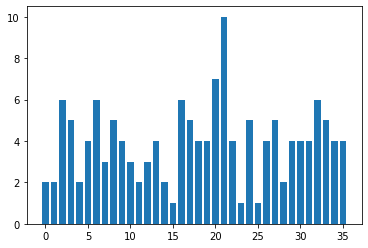

In [170]:
cluster_counter = Counter(cluster)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [171]:
probs.std(axis=1)

array([0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433555,
       0.16433555, 0.16433555, 0.16433555, 0.16433555, 0.16433

In [172]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(cluster)))


fig.show()

Need more colors than current cmap holds


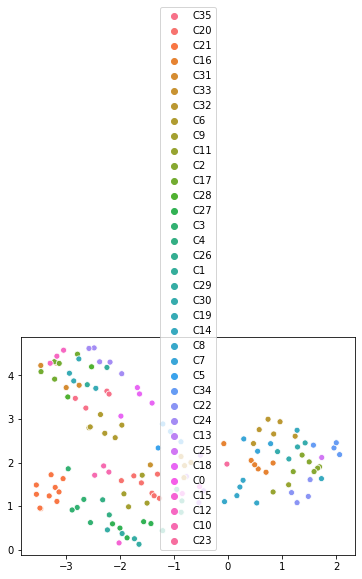

In [173]:
import seaborn as sns
sns.scatterplot(x=Xr[:, 0],
                y=Xr[:, 1],
               hue=[f'C{i}' for i in cluster])

In [174]:
dfs = get_cluster_dfs(aggr, cluster)

In [175]:
for cluster_df in dfs:
    print(cluster_df.label)
    print(f'Total number of movies in cluster => {cluster_df.n_texts.sum()}')
    print('#'*60)

45     French, Italian
121     Greek, English
Name: label, dtype: object
Total number of movies in cluster => 7
############################################################
20     English, Japanese
68    English, Cantonese
Name: label, dtype: object
Total number of movies in cluster => 21
############################################################
10              Mandarin
34     Mandarin, English
49                 Greek
65            Vietnamese
90     Min Nan, Mandarin
127                Malay
Name: label, dtype: object
Total number of movies in cluster => 53
############################################################
15                          Dutch
59                 Dutch, English
80              Norwegian, German
115    Norwegian, English, German
123                       Serbian
Name: label, dtype: object
Total number of movies in cluster => 32
############################################################
16                     Danish
141    Flemish, French, Dutch
Name: label, 